# Assignment 1: SARSA & Q-Learning Algorithms

In [174]:
from math import floor
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from IPython.display import clear_output
import time
%matplotlib inline

import gridworld
from gridworld import *

## 1. Environment Details

In [175]:
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
actions = [UP, DOWN, LEFT, RIGHT]

In [176]:
#Heatmap function
def plot_Q(Q, message = "Q plot"):
    
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        return 1 if a == UP else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()

In [177]:
#World parameters
num_rows = 10
num_cols = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[0,4]])
goal_states = np.array([[0,9],[2,2],[8,7]])

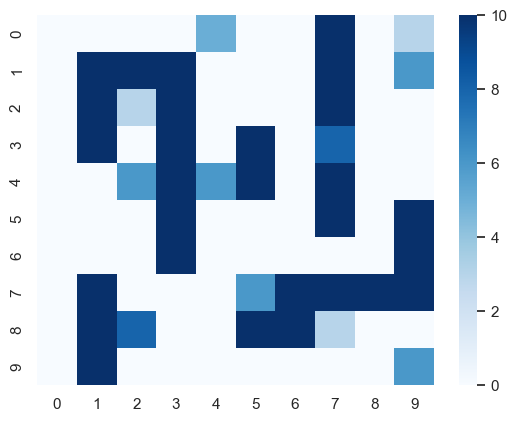

[[ 0.  0.  0.  0.  5.  0.  0. 10.  0.  3.]
 [ 0. 10. 10. 10.  0.  0.  0. 10.  0.  6.]
 [ 0. 10.  3. 10.  0.  0.  0. 10.  0.  0.]
 [ 0. 10.  0. 10.  0. 10.  0.  8.  0.  0.]
 [ 0.  0.  6. 10.  6. 10.  0. 10.  0.  0.]
 [ 0.  0.  0. 10.  0.  0.  0. 10.  0. 10.]
 [ 0.  0.  0. 10.  0.  0.  0.  0.  0. 10.]
 [ 0. 10.  0.  0.  0.  6. 10. 10. 10. 10.]
 [ 0. 10.  8.  0.  0. 10. 10.  3.  0.  0.]
 [ 0. 10.  0.  0.  0.  0.  0.  0.  0.  6.]]


In [178]:
#Visualising the grid
def heatmap(num_rows, num_cols, obstructions, bad_states, restart_states, start_state, goal_states):
    
    grid = np.zeros([num_rows, num_cols])
    state_list = [obstructions, bad_states, restart_states, start_state, goal_states]
    for i in range(len(state_list)):
        for r in range(state_list[i].shape[0]):
            grid[state_list[i][r][0], state_list[i][r][1]] = heat[i]
    return grid

heat = [10, 6, 8, 5, 3]
grid = heatmap(num_rows, num_cols, obstructions, bad_states, restart_states, start_state, goal_states)
sns.set()
ax = sns.heatmap(grid, vmin=0, vmax=10, cmap="Blues")
sns.color_palette("tab10")
plt.show()
print(grid)

## 2. Creating Grid World

In [266]:
#Creating model
gw = gridworld.GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)

gw.add_transition_probability(p_good_transition=1.0, bias=0.5)

env = gw.create_gridworld()

In [180]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


## 3. Learning Algorithms: Q Learning & SARSA

### Exploration strategies
1. Epsilon-greedy
2. Softmax

In [181]:
#Hyperparameters
episodes = 10000
test_episodes = 1000
max_steps = 100

In [182]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

#Epsilon greedy
def choose_action_epsilon(Q, state, epsilon, rg=rg):
    if rg.rand() < epsilon:
        return rg.randint(len(actions))
    else:
        return np.argmax(Q[state[0,0]][state[0,1]])

#Softmax
def choose_action_softmax(Q, state, beta, rg=rg):
    prob = softmax(Q[state[0,0]][state[0,1]]/beta)
    best_action = rg.choice(actions, p = prob)
    return best_action

### 3.1 SARSA Algorithm
Update equation:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]
\end{equation}

#### Hyperparameters

We have 3 hyperparameters for the algorithm:
- $\alpha$
- number of *episodes*.
- $\epsilon$: For epsilon greedy exploration

In [246]:
print_freq = 100

def sarsa(env, Q, alpha, policy_parameter, gamma, episodes, plot_heat, choose_action):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)

    state_visits = np.zeros((num_rows, num_cols))
    for ep in range(episodes):
        tot_reward, steps = 0, 0
        
        #Reset environment
        state = env.reset()
        action = choose_action(Q, seq_to_col_row(state, num_cols), policy_parameter)

        while steps<max_steps:
            state_next, reward = env.step(state, action)
            state_rc = seq_to_col_row(state, num_cols)
            state_next_rc = seq_to_col_row(state_next, num_cols)
            state_visits[state_rc[:,0], state_rc[:,1]] += 1

            #print(state_next,gw.goal_states_seq)
            if any(np.sum(np.abs(gw.goal_states-state_rc),1)==0):
                break
            action_next = choose_action(Q, seq_to_col_row(state_next, num_cols), policy_parameter)
            
            Q[state_rc[:,0], state_rc[:,1], actions.index(action)] = Q[state_rc[:,0], state_rc[:,1], actions.index(action)] + alpha*(reward + gamma*Q[state_next_rc[:,0], state_next_rc[:,1], actions.index(action_next)] - Q[state_rc[:,0], state_rc[:,1], actions.index(action)])
                                                    
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = f"alpha={alpha},gamma={gamma},epsilon={policy_parameter} "+"Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion, state_visits

### 3.2 Q-Learning Algorithm
Update rule for Q-Learning:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)]
\end{equation}

In [247]:
print_freq = 100

def qlearning(env, Q, alpha, policy_parameter, gamma, episodes, plot_heat, choose_action):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)

    state_visits = np.zeros((num_rows, num_cols)) 
    for ep in range(episodes):
        tot_reward, steps = 0, 0
        
        #Reset environment
        state = env.reset()
        action = choose_action(Q, seq_to_col_row(state, num_cols), policy_parameter)

        while steps<max_steps:
            state_next, reward = env.step(state, action)
            state_rc = seq_to_col_row(state, num_cols)
            state_next_rc = seq_to_col_row(state_next, num_cols)
            state_visits[state_rc[:,0], state_rc[:,1]] += 1

            if any(np.sum(np.abs(gw.goal_states-state_rc),1)==0):
                break
            
            action_next = choose_action(Q, seq_to_col_row(state_next, num_cols), policy_parameter)
            
            Q[state_rc[:,0], state_rc[:,1], actions.index(action)] = Q[state_rc[:,0], state_rc[:,1], actions.index(action)] + alpha*(reward + gamma*np.max(Q[state_next_rc[:,0], state_next_rc[:,1], :]) - Q[state_rc[:,0], state_rc[:,1], actions.index(action)])
                                                    
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion, state_visits

# 4. Hyperparameter Search
Performing search for optimum set hyperparameters for each of the 16 configurations for each algorithm.

In [185]:
#Initializing test hyperparameters 
test_steps = []
test_rewards = []

#Choosing values both emperically and after some test runs
test_alpha_list = [0.001, 0.4, 0.9]
test_epsilon_list = [0.0001, 0.2]
test_beta_list = [0.1, 1.0, 5.0]
test_gamma_list = [0, 0.4, .9]

test_parameters = [test_alpha_list, test_beta_list, test_epsilon_list, test_gamma_list]
parameter_names = ['Alpha', 'Beta', 'Epsilon', 'Gamma']

In [186]:
def optimum_combination_steps(test_array, test_policy_parameter):
    '''
    Output
    ---------
    output 1: float
        Optimum value of alpha
    output 2: float
        Optimum value of policy parameter
    output 3: folat
        Optimum value of gamma
    
    Returns the optimum values of the parameters based on the least amount of steps taken to reach the goal state.
    
    Parameters
    ----------
    test_array : numpy array of either shape (3, 2, 3) or (3, 3, 3) depending on the exploration strategy
        Average steps for each possible combination of parameters
    test_policy_parameter : list of either length 2 or 3
        List of different exploration strategy parameter values
    '''
    indices = np.where(test_array == np.min(test_array))
    return test_alpha_list[indices[0][0]], test_policy_parameter[indices[1][0]], test_gamma_list[indices[2][0]]

def hyperparam_search(algorithm, plot_heat):
    
    #Initializing matrices for optimum params
    optimum_alpha_ep = np.zeros((2,2,2))
    optimum_alpha_soft = np.zeros((2,2,2))

    optimum_epsilon_ep = np.zeros((2,2,2))

    optimum_beta_soft = np.zeros((2,2,2))

    optimum_gamma_ep = np.zeros((2,2,2))
    optimum_gamma_soft = np.zeros((2,2,2))

    configuration = 1

    #Looping over all configurations
    for wind in [False, True]:
        for start_state in [np.array([[0,4]]), np.array([[3,6]])]:
            for p_good_transition in [1.0, 0.7]:
            
                gw = gridworld.GridWorld(num_rows=num_rows, num_cols=num_cols, start_state=start_state, goal_states=goal_states, wind=wind)
                gw.add_obstructions(obstructed_states=obstructions, bad_states=bad_states, restart_states=restart_states)
                gw.add_rewards(step_reward=-1, goal_reward=10, bad_state_reward=-6, restart_state_reward=-100)
                gw.add_transition_probability(p_good_transition=p_good_transition, bias=0.5)
                env = gw.create_gridworld()
                
                if wind == False:
                    i = 0
                else: 
                    i = 1

                if (start_state == np.array([[0,4]])).all():
                    j = 0
                else:
                    j = 1
                
                if p_good_transition == 1.0:
                    k = 0
                else:
                    k = 1

                test_steps_ep = np.zeros((3, 2, 3))
                test_rewards_ep = np.zeros((3, 2, 3))

                if configuration == 1:
                    print(f"Running\033[1m {algorithm.__name__}\033[0m algorithm")
                print(f"Searching for configuration: {configuration}", "\r")
                
                start = time.time()
                for alpha in test_parameters[0]:
                    for epsilon in test_parameters[2]:
                        for gamma in test_parameters[3]:
                            Q = np.zeros((env.num_rows, env.num_cols, len(actions)))    
                            Q, rewards, steps, state_visits = algorithm(env, Q, alpha, epsilon, gamma, test_episodes, plot_heat, choose_action = choose_action_epsilon)
                            test_steps_ep[test_parameters[0].index(alpha), test_parameters[2].index(epsilon), test_parameters[3].index(gamma)] = np.mean(steps)
                            test_rewards_ep[test_parameters[0].index(alpha), test_parameters[2].index(epsilon), test_parameters[3].index(gamma)] = np.mean(rewards)

                test_steps_soft = np.zeros((3, 3, 3))
                test_rewards_soft = np.zeros((3, 3, 3))
                
                for alpha in test_parameters[0]:
                    for beta in test_parameters[1]:
                        for gamma in test_parameters[3]:
                            Q = np.zeros((env.num_rows, env.num_cols, len(actions)))    
                            Q, rewards, steps, state_visits = algorithm(env, Q, alpha, beta, gamma, test_episodes, plot_heat, choose_action = choose_action_softmax)
                            test_steps_soft[test_parameters[0].index(alpha), test_parameters[1].index(beta), test_parameters[3].index(gamma)] = np.mean(steps)
                            test_rewards_soft[test_parameters[0].index(alpha), test_parameters[1].index(beta), test_parameters[3].index(gamma)] = np.mean(rewards)

                end = time.time()

                a, e, g = optimum_combination_steps(test_steps_ep, test_epsilon_list)
                optimum_alpha_ep[i, j, k] = a
                optimum_epsilon_ep[i, j, k] = e
                optimum_gamma_ep[i, j, k] = g
                # optimum_combination_rewards(test_rewards_soft, test_epsilon_list)
                a, b, g = optimum_combination_steps(test_steps_soft, test_beta_list)
                # optimum_combination_rewards(test_rewards_soft, test_beta_list)
                optimum_alpha_soft[i, j, k] = a
                optimum_beta_soft[i, j, k] = b
                optimum_gamma_soft[i, j, k] = g

                print(f"Time of execution for configuration {configuration} = {end-start}s")
                configuration += 1

    return [[optimum_alpha_ep, optimum_epsilon_ep, optimum_gamma_ep], [optimum_alpha_soft, optimum_beta_soft, optimum_gamma_soft]]  

Control the *plot_heat* function as you like!

In [187]:
optimum_sarsa = hyperparam_search(sarsa, plot_heat=False)
optimum_qlearning = hyperparam_search(qlearning, plot_heat=False)

Running sarsa algorithm
Searching for configuration: 1 
Time of execution for configuration 1 = 99.80364179611206s
Running sarsa algorithm
Searching for configuration: 2 
Time of execution for configuration 2 = 105.36436986923218s
Running sarsa algorithm
Searching for configuration: 3 
Time of execution for configuration 3 = 95.55157804489136s
Running sarsa algorithm
Searching for configuration: 4 
Time of execution for configuration 4 = 107.16233491897583s
Running sarsa algorithm
Searching for configuration: 5 
Time of execution for configuration 5 = 106.76092505455017s
Running sarsa algorithm
Searching for configuration: 6 
Time of execution for configuration 6 = 114.28318500518799s
Running sarsa algorithm
Searching for configuration: 7 
Time of execution for configuration 7 = 97.60410404205322s
Running sarsa algorithm
Searching for configuration: 8 
Time of execution for configuration 8 = 111.46250104904175s
Running qlearning algorithm
Searching for configuration: 1 
Time of executi

# 5. Plots
In this section we plot: 
1. Steps vs episodes
2. Total reward vs episodes 

for Q-Learning with case:
1. wind = *False* 
2. start state = np.array([3,6])
3. transition probability = 0.7 <br /> <br />

To plot for the other cases, simply access the values from *optimum_qlearning* or *optimum_sarsa*

In [284]:
#test hyperparameters
#optim_sarsa is nested as type of strategy -> parameter type -> wind -> start state -> transition probability
#further clear by looking at hyperparam_search function
test_alpha = optimum_qlearning[1][0][0][1][1]
test_policy_parameter = optimum_qlearning[1][1][0][1][1]
test_gamma = optimum_qlearning[1][2][0][1][1]

Running 5 experiments to minimise the variance in steps and total reward due to the stochasticity of the model

In [285]:
num_expts = 5
reward_avgs, steps_avgs = [], []

#Creating model based on the case taken
gw = gridworld.GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=np.array([[3,6]]), #modify start state if needed
               goal_states=goal_states, wind = False) #modify wind if needed
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)

gw.add_transition_probability(p_good_transition=0.7, bias=0.5) #modify p_good_transition if needed

env = gw.create_gridworld()

for i in range(num_expts):
    
    Q = np.zeros((env.num_rows, env.num_cols, len(actions)))
    rg = np.random.RandomState(i)

    Q, rewards, steps, _ = qlearning(env, Q, test_alpha, test_policy_parameter, test_gamma, episodes=test_episodes, plot_heat=False, choose_action=choose_action_softmax)
    steps_avgs.append(steps)
    reward_avgs.append(rewards)

steps_avgs = np.sum(steps_avgs,axis=0)/num_expts
reward_avgs = np.sum(reward_avgs,axis=0)/num_expts

Experiment: 1
Experiment: 2
Experiment: 3
Experiment: 4
Experiment: 5


steps needed after 1000 episodes: 37.8


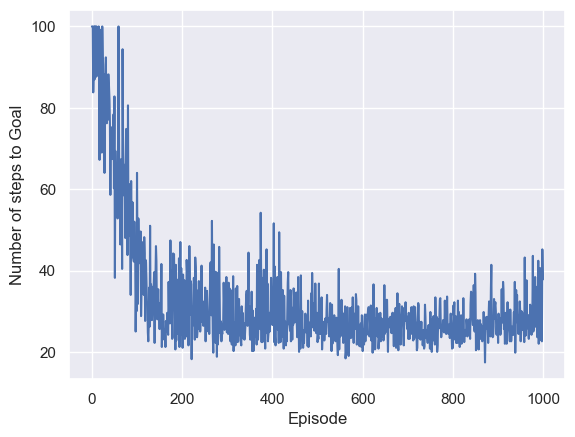

Reward achieved after 1000 episodes: -31.0


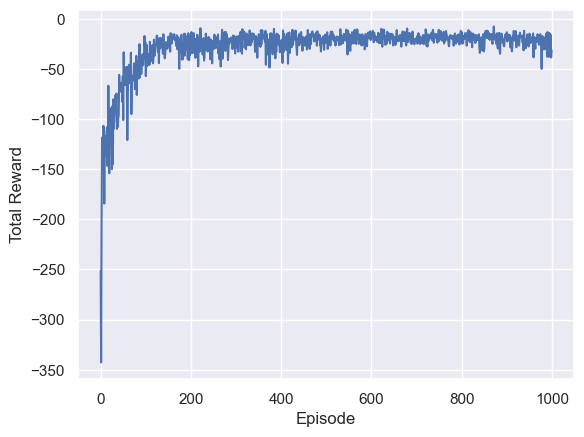

In [286]:
#Steps vs episode plot
plt.figure()
print(f"steps needed after {test_episodes} episodes: {steps_avgs[-1]}")
plt.plot(range(1000), steps_avgs)
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.show()

#Total reward vs episode plot
plt.figure()
print(f"Reward achieved after {test_episodes} episodes: {reward_avgs[-1]}")
plt.plot(range(1000), reward_avgs)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()